# Porto Seguro Tutorial by Bert Carremans - First Try

Porto Seguro는 브라질의 자동차 보험 회사로, 이 데이터셋을 활용하여 **어떤 차주가 내년에 보험 청구를 할 확률을 예측**하는 것이 본 대회의 목적이다. 

## 1. Loading Packages

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer    # 0.22 버전부터 삭제
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

# pandas에서 dataset을 볼 때
# 최대 100 cols까지 보게 설정
pd.set_option('display.max_columns', 100)

> `❗ CAUTION`  
> Imputer는 Sklearn 0.22버전부터 삭제되고 **SimpleImputer**로 대체되었다. 해당 노트북에 있는 comment을 참고하여 Imputer를 쓰는 부분은 SimpleImputer를 사용하는 코드로 대체될 예정.

## 2. Loading Data

In [113]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

## 3. Data at First Sight
다음은 대회에서 첨부한 데이터셋 설명이다:
* **유사한 집단**의 피처들은 **똑같은 피처 이름**으로 태그 된다.
* 뒤에 `bin`이라는 단어를 포함한 경우 **binary**함을, 앞에 `cat`이라는 단어를 포함하는 경우 **categorical**한 피처임을 말한다.
* 위의 표시가 없는 피처들은 **continous하거나 ordinal**하다.
* `-1`은 결측치(missing value)를 말한다.
* `target` 피처는 보험을 청구했는지 여부를 나타낸다.

In [114]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [115]:
train.tail()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
595207,1488013,0,3,1,10,0,0,0,0,0,1,0,0,0,0,0,13,1,0,0,0.5,0.3,0.692820,10,1,-1,0,1,1,1,1,0,1,31,3,0.374166,0.684631,0.385487,2.645751,0.4,0.5,0.3,3,0,9,0,9,1,12,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.9,0.7,1.382027,9,1,-1,0,-1,15,0,0,2,1,63,2,0.387298,0.972145,-1.000000,3.605551,0.2,0.2,0.0,2,4,8,6,8,2,12,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,0,0,0,0,0,0,12,1,0,0,0.9,0.2,0.659071,7,1,-1,0,-1,1,1,1,2,1,31,3,0.397492,0.596373,0.398748,1.732051,0.4,0.0,0.3,3,2,7,4,8,0,10,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.9,0.4,0.698212,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.764434,0.384968,3.162278,0.0,0.7,0.0,4,0,9,4,9,2,11,4,1,4,2,0,1,1,1,0,0
595211,1488027,0,0,1,8,0,0,1,0,0,0,0,0,0,0,0,7,1,0,0,0.1,0.2,-1.000000,7,0,-1,0,-1,0,1,0,2,1,34,2,0.400000,0.932649,0.378021,3.741657,0.4,0.0,0.5,2,3,10,4,10,2,5,4,4,3,8,0,1,0,0,0,0


위의 데이터셋을 보고 피처를 다음과 같이 구분할 수 있다.
* **binary**한 피처들
* 값이 정수인 **categorical** 피처들
* **정수 혹은 실수 값**을 가지고 있는 피처들
* 결측치를 나타내는 `-1`을 가지고 있는 피처들
* **target** 피처와 **ID** 피처

In [116]:
train.shape

(595212, 59)

train 데이터셋은 59개의 피처와 595,212개의 데이터를 가지고 있다.

In [117]:
# 중복된 row를 제거한 dataframe 반환
train.drop_duplicates()
train.shape

(595212, 59)

위의 크기와 같으므로 중복된 데이터는 없다.

In [118]:
test.shape

(892816, 58)

test 데이터셋에서는 target label 하나가 없어서 피처의 개수가 58개이다. 

In [119]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

`info()`를 통해 **각 피처의 데이터 타입과 null 값이 있는지 여부**를 알 수 있다. 결과를 보아 null 값은 없으나 결측치가 -1로 대체되었으므로 나중에 이에 대해 다시 볼 예정이다.

## 3. Metadata
데이터를 쉽게 다루기 위해서, DataFrame에 피처에 대한 meta 정보를 저장할 것이다. 분석, 시각화, 모델링 등에 특정 피처를 사용하고 싶을 때 매우 도움이 될 것이다.

그래서 우리는 다음과 같은 메타 데이터를 생성할 것이다:
* **role** : input, ID, target
* **level** : nominal, interval, ordinal, binary
* **keep** : True, False
* **dtype** : int, float, str

> `💡 TIP` 데이터의 종류   
> * **norminal** : 하나의 카테고리로 분류가 가능하지만 순서는 매길 수 없고 그냥 셀 수만 있는 데이터
>     * 평균을 계산하는 것이 의미가 없고 비율로 표현하는 건 OK
>     * `ex` 여자/남자, 청팀/홍팀/백팀
> * **ordinal** : 카테고리에 순서가 있는 데이터
>     * 이런 데이터를 가지고 평균을 낼 경우 신중해야 한다. 왜냐하면 수치 자체에는 특별한 의미가 잇는 것이 아니기 떄문.
>     * `ex` 매우낮다/낮다/중립/높다/매우낮다
> * **interval** : 하루 중 특정 시점을 나타내는 시간 데이터
>     * 데이터의 연속된 측정 구간 사이의 간격이 동일한 경우도 interval 데이터라고 부른다.
>     * numeric한 값을 가지므로 다양한 연산이 가능하다.
>     * 절대적 원점이 없다. 예를 들면, `00:00`은 그냥 그 때 측정했다는 말.
> * **ratio** : 절대적 원점이 존재하여 그 원점과 어떤 시점 사이의 차이
>     * `ex` 나이, 돈, 몸무게
> * **discrete / continous** : 딱딱 떨어지느냐 / 연속적인 값으로 표현되느냐
>     * interval이나 ratio 데이터는 discrete나 continous 둘 중 하나의 속성을 갖게 된다.

In [120]:
data = []    # 메타 데이터를 저장할 리스트

for f in train.columns:
    # role 설정
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'

    # level 설정
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif train[f].dtype == np.float64:
        level = 'interval'
    elif train[f].dtype == np.int64:
        level = 'ordinal'

    # keep 설정
    # id 빼고는 모두 True
    keep = True
    if f == 'id':
        keep = False

    # datatype 설정
    dtype = train[f].dtype

    # 각 피처에 대한 메타 데이터 생성
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)

In [121]:
meta = pd.DataFrame(data, columns=['varname','role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


만약 특정 성격을 가지고 있는 피처만 뽑아내고 싶다면 다음과 같이 하면 된다. 다음의 예씨는 **nominal한 피처를 뽑아내는 경우**이다.

> `❗ CAUTION`    
> 노트북에는 그냥 `int`와 `float`를 쓰지만, 해당 cell을 돌리면 인식이 안되는 버그가 있음. 일단 `dtype`의 자료형은 numpy의 자료형임. 그래서 `np.int64`와 `np.float64`로 바꿔주면 노트북대로 잘 돌아간다.

In [122]:
meta[(meta.level == 'nominal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

다음은 `role`과 `level`에 따른 피처의 개수이다.

In [123]:
# 1. role과 level만 추출해 role을 기준으로 grouping
# 2. 그 떄의 크기를 count key의 value로 둚
# 3. 이 dict를 dataframe으로 변환
# 4. index를 다시 차례대로 부여
pd.DataFrame({'count': meta.groupby(['role', 'level'])[
             'role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


## 4. Descriptive Statistics
`describe()` 함수를 통해 간단한 통계를 낼 수 있지만 **categorical** 피처와 id의 경우 적용되지 않는다.

이번에는 categorical 피처를 시각화하는 법을 알아보자.

### 4.1. Interval Features

In [124]:
# interval 피처들만 추출 (이름)
# 이 때 반환되는 것은 Index 객체
v = meta[(meta.level == 'interval') & (meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


`🔍 OBSERVATION`   
* **reg features** 
 * `ps_reg_03`만 결측치가 존재한다.
 * 피처마다 최대, 최소 즉 범위가 다르다. scaling하는 방법도 있지만 우리가 사용할 classifier에 따라 달라질 수 있음.
* **car features**
 * `ps_car_12`와 `ps_car_15`는 결측치가 존재한다.
 * **reg**와 마찬가지로 각 피처의 범위가 다르므로 scaling을 해볼 수 있다.
* **calc features**
 * 모든 피처에 결측치가 없다.
 * 몇몇 피처가 최대값이 `0.9`이다.
 * 그리고 이 피처들은 매우 비슷한 분포(distribution)을 가지고 있다.
 
전체적으로 interval 피처들의 값들이 다소 작은 것을 볼 수 있다. 아마 <u>데이터를 익명화하기 위해 log 변환 같은 변환을 쓴 것</u>으로 보인다.
  

### 4.2. Ordinal Features

In [125]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


`🔍 OBSERVATION`   
* `ps_car_11`만 결측치가 존재한다.
* 서로 범위가 다르므로 scaling 방식을 적용해볼 수 있다.

### 4.3. Binary Features

In [126]:
v = meta[(meta.level == 'binary') & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


`🔍 OBSERVATION`   
* `target == 1`인 데이터는 **3.645%**를 차지한다. 매우 극단적으로 불균형적(imbalanceD)이다.
* 평균(mean)에서 보다싶이 대부분의 피처들이 0에 가까운 것을 볼 수 있다.

## 5. Handling imbalanced classes

앞에서 봤다싶이 `target == 1`인 데이터가 `target == 0`인 데이터에 비해 매우 적다. 이렇게 학습시킨 모델은 정확도가 높을 수는 있지만, 모델 설계시 데이터를 더 추가시켜야 한다. 이를 해결할 수 있는 두 가지 방법이 있다.
* **방법 1** : `target == 1`인 데이터를 oversampling
* **방법 2** : `target == 0`인 데이터를 undersampling

우리는 매우 큰 데이터셋을 가지고 있으므로 **undersampling 방식**을 사용할 것이다.

> **DataFrame.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')**   
> DataFrame의 index를 말 그대로 reset시켜준다.
> * `drop` : DataFrame에 그 전에 있던 index를 column으로 추가할건지

In [127]:
desired_apriori = 0.10    # 원하는 target == 1의 비율

# 각 target value의 index 추출
idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

# 각 target value의 데이터 개수
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# undersampling rate
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
# undersampling시 최종 target==0의 개수
undersampled_nb_0 = int(undersampling_rate*nb_0)

print('Rate to undersample records with target=0 : {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling : {}'.format(undersampled_nb_0))

# target=0의 index 중 10%을 임의로 선발 
undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

# 남은 index를 가지고 리스트 생성
idx_list = list(undersampled_idx) + list(idx_1)

# undersampled된 DataFrame 생성
train = train.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0 : 0.34043569687437886
Number of records with target=0 after undersampling : 195246


## 6. Data Quality Checks
### 6.1. Checking Missing Values
결측치(missing value)는 `-1`로 표현된다.

In [128]:
vars_with_missing = []    # missing value를 갖는 피처 리스트

for f in train.columns:
    missings = train[train[f] == -1][f].count()    # missing value 개수
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings / train.shape[0]  # missing value 비율
        
        print('Feature {} has {} records ({:.2%}) with missing values.'.format(f, missings, missings_perc))

print('In total, there are {} features with missing values.'.format(len(vars_with_missing)))

Feature ps_ind_02_cat has 103 records (0.05%) with missing values.
Feature ps_ind_04_cat has 51 records (0.02%) with missing values.
Feature ps_ind_05_cat has 2256 records (1.04%) with missing values.
Feature ps_reg_03 has 38580 records (17.78%) with missing values.
Feature ps_car_01_cat has 62 records (0.03%) with missing values.
Feature ps_car_02_cat has 2 records (0.00%) with missing values.
Feature ps_car_03_cat has 148367 records (68.39%) with missing values.
Feature ps_car_05_cat has 96026 records (44.26%) with missing values.
Feature ps_car_07_cat has 4431 records (2.04%) with missing values.
Feature ps_car_09_cat has 230 records (0.11%) with missing values.
Feature ps_car_11 has 1 records (0.00%) with missing values.
Feature ps_car_14 has 15726 records (7.25%) with missing values.
In total, there are 12 features with missing values.


`🔍 OBSERVATION`   
* `ps_car_03_cat`과 `ps_car_05_cat`는 많은 부분이 missing value이므로 삭제!
* 그 외에 **categorical** 피처는 -1 그대로 놔둠.
* `ps_reg_03`는 **continuous**한 피처로 18%가 missing value임 → 평균값으로 채움
* `ps_car_11`는 **ordinal**한 피처로 단 5개의 missing value가 존재 → 가장 많은 횟수의 값(mode)으로 채움
* `ps_car_12`는 **continous**한 피처로 오직 1개의 missing value가 존재 → 평균값으로 채움
* `ps_car_14`는 **continous**한 피처로 7%가 missing value임 → 평균값으로 채움 

In [129]:
# 너무 많은 missing value를 갖고 있는 피처는 드롭!
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, inplace=True, axis=1)

# meta 데이터 변경 : 더이상 사용하지 않는 걸로
meta.loc[(vars_to_drop), 'keep'] = False    

# SimpleImputer로 mean과 mode로 채움
mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')

train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()

> **class sklearn.impute.SimpleImputer(*, missing_values=nan, strategy='mean', fill_value=None)**     
> 결측치를 채우는 클래스
> * `missing_value` : 결측치의 형태. NaN일 경우 `np.nan`으로 표시.
> * `strategy` : 어떻게 결측치를 채울건지.
>    * mean, median, most_frequent, const 4가지 중 하나 
> * `fill_value` : 만약 `strategt`가 const일 경우 채울 값. 기본 값은 0.    
>
> 메서드가 궁금하다면 [여기](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) 참고

> **numpy.ravel()**   
> 다차원 배열을 1차원 배열로 펴주는 함수 

### 6.2. Checking the Cardinality of the Categorical Features
Cardinality는 **전체 데이터에 대해 한 피처의 데이터 중복 정도**를 말한다. 나중에 categorical 피처의 dummy 피처를 만들 예정인데, 해당 피처가 많은 유일한(unique, distinct) 값을 가지고 있는지 확인해주어야 한다. 왜냐하면 그만큼의 유일수의 개수만큼 dummy 피처를 생성해줘야 하기 때문이다. 그래서 너무 유일수가 많을 경우 dummy 피처를 만들지 않는다.

In [130]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    dist_values = train[f].value_counts().shape[0]    # 유일수의 개수
    print('Feature {} has {} distinct values.'.format(f, dist_values))

Feature ps_ind_02_cat has 5 distinct values.
Feature ps_ind_04_cat has 3 distinct values.
Feature ps_ind_05_cat has 8 distinct values.
Feature ps_car_01_cat has 13 distinct values.
Feature ps_car_02_cat has 3 distinct values.
Feature ps_car_04_cat has 10 distinct values.
Feature ps_car_06_cat has 18 distinct values.
Feature ps_car_07_cat has 3 distinct values.
Feature ps_car_08_cat has 2 distinct values.
Feature ps_car_09_cat has 6 distinct values.
Feature ps_car_10_cat has 3 distinct values.
Feature ps_car_11_cat has 104 distinct values.


`ps_car_11_cat`만 매우 많은 유일수를 가지고 있다. 다음은 `ps_car_11_cat`과 같이 cardinality가 높은 categorical 데이터를 encoding하는 방법이다.     
하지만 이해하지는 못했다😥

> **논문 출처** : http://helios.mm.di.uoa.gr/~rouvas/ssi/sigkdd/sigkdd.vol3.1/barreca.pdf

In [136]:
# reference : https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))


def target_encode(trn_series=None, tst_series=None, target=None, min_samples_leaf=1, smoothing=1, noise_level=0):
    '''
    trn_series : (pd.Series) train 데이터의 categorical 피처
    tst_series : (pd.Series) test 데이터의 categorical 피처
    target : (pd.Series) target 피처
    min_samples_leaf : (int) leaf 노드가 되기 위한 최소한의 샘플 개수
    smoothing : (int) smoothing 정도
    '''
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)

    # 카테고리별 target의 평균과 개수를 계산
    averages = temp.groupby(by=trn_series.name)[
        target.name].agg(['mean', 'count'])
    # smoothing 계산
    smoothing = 1 / \
        (1 + np.exp(-(averages['count'] - min_samples_leaf) / smoothing))

    # average func을 모든 target 데이터에 적용
    prior = target.mean()
    # 개수가 많을수록 full_avg는 덜 고려됨
    averages[target.name] = prior * \
        (1 - smoothing) + averages['mean'] * smoothing
    averages.drop(['mean', 'count'], axis=1, inplace=True)

    # averages를 train 그리고 test series에 적용
    ft_trn_series = pd.merge(trn_series.to_frame(trn_series.name), averages.reset_index().rename(columns={
        'index': target.name, target.name: 'average'}), on=trn_series.name, how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    ft_tst_series = pd.merge(tst_series.to_frame(tst_series.name), averages.reset_index().rename(columns={
        'index': target.name, target.name: 'average'}), on=tst_series.name, how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)

    # pd.merge는 index가 없으므로 다시 생성
    ft_trn_series.index= trn_series.index
    ft_tst_series.index = tst_series.index

    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [137]:
train_encoded, test_encoded = target_encode(
    train['ps_car_11_cat'], test['ps_car_11_cat'], target=train.target, min_samples_leaf=100, smoothing=10, noise_level=0.01)

train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat', 'keep'] = False
test['ps_cat_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

### 6.3. Testing with ps_car_11_cat

In [139]:
# 데이터 로드
trn_df = pd.read_csv('../data/train.csv', index_col=0)
sub_df = pd.read_csv('../data/test.csv', index_col=0)

# target이 ps_car_11_cat을 encoding
trn, sub = target_encode(trn_df['ps_car_11_cat'], sub_df['ps_car_11_cat'], target=trn_df.target, min_samples_leaf=100, smoothing=10, noise_level=0.01)
trn.head(10)

id
7     0.039095
9     0.024001
13    0.031298
16    0.044716
17    0.025845
19    0.045119
20    0.023408
22    0.030405
26    0.034124
28    0.044015
Name: ps_car_11_cat_mean, dtype: float64

## 7. Exploratory Data Visualization

### 7.1. Categorical Features

<Figure size 432x288 with 0 Axes>

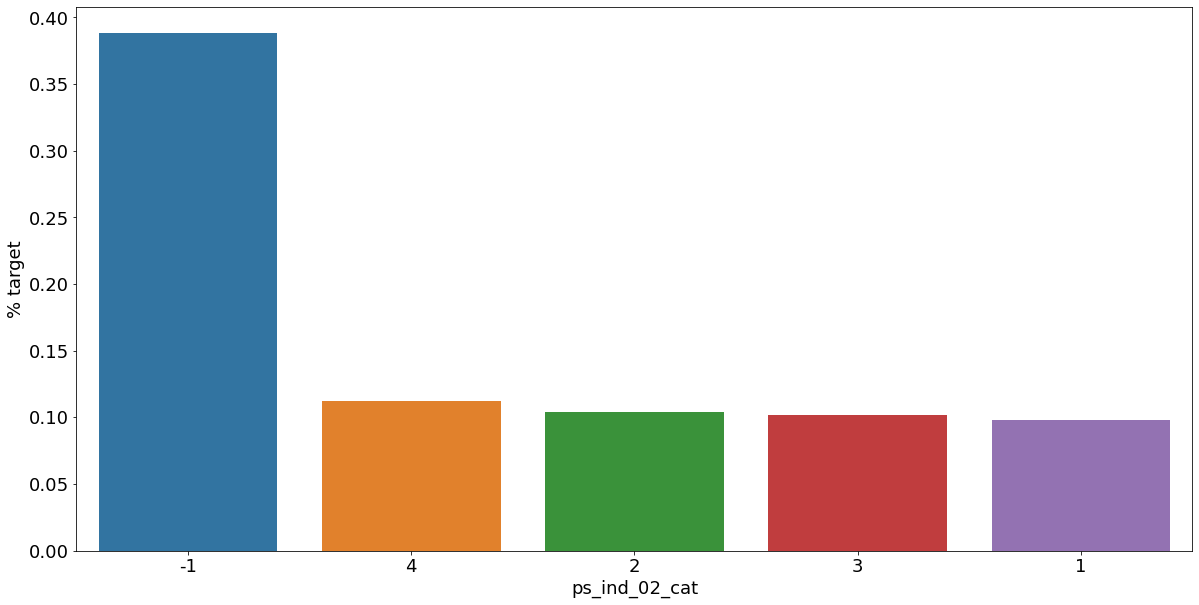

<Figure size 432x288 with 0 Axes>

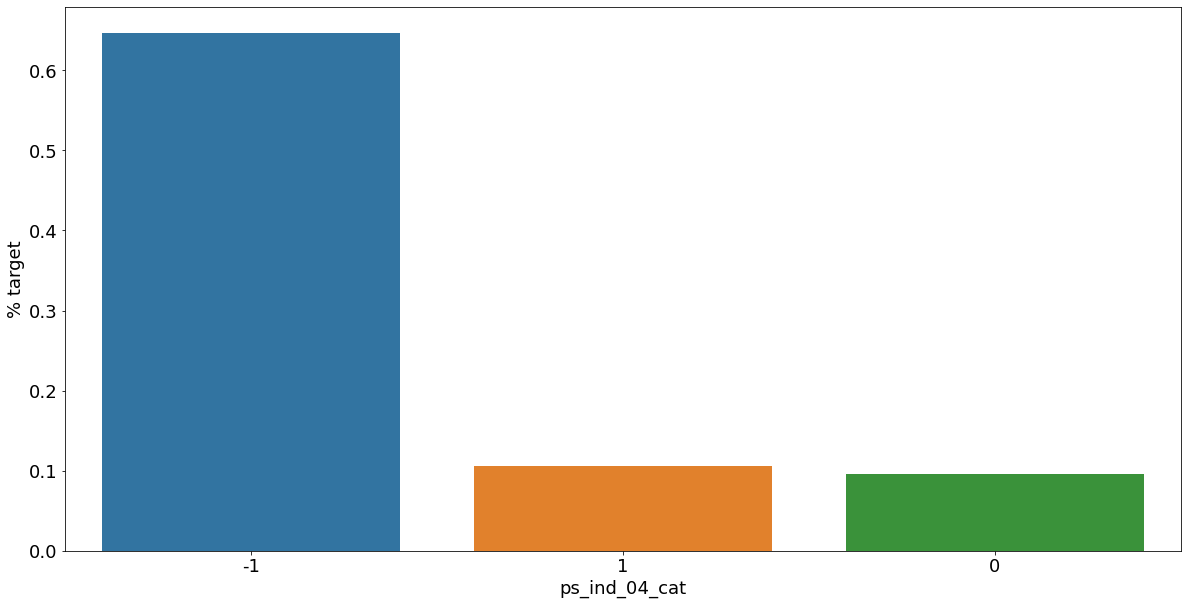

<Figure size 432x288 with 0 Axes>

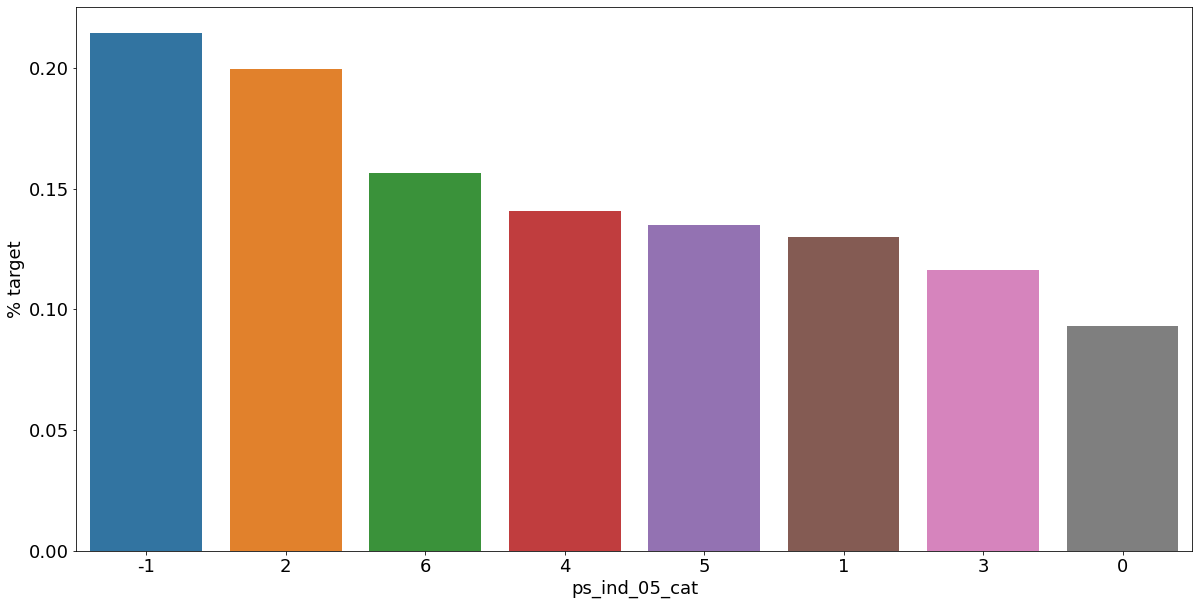

<Figure size 432x288 with 0 Axes>

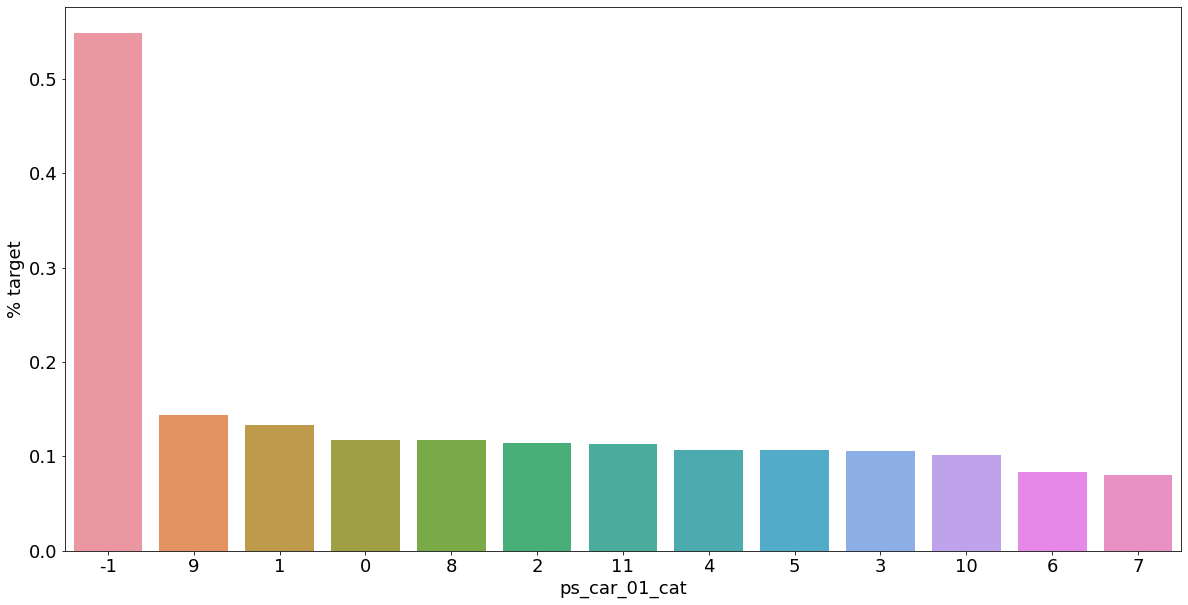

<Figure size 432x288 with 0 Axes>

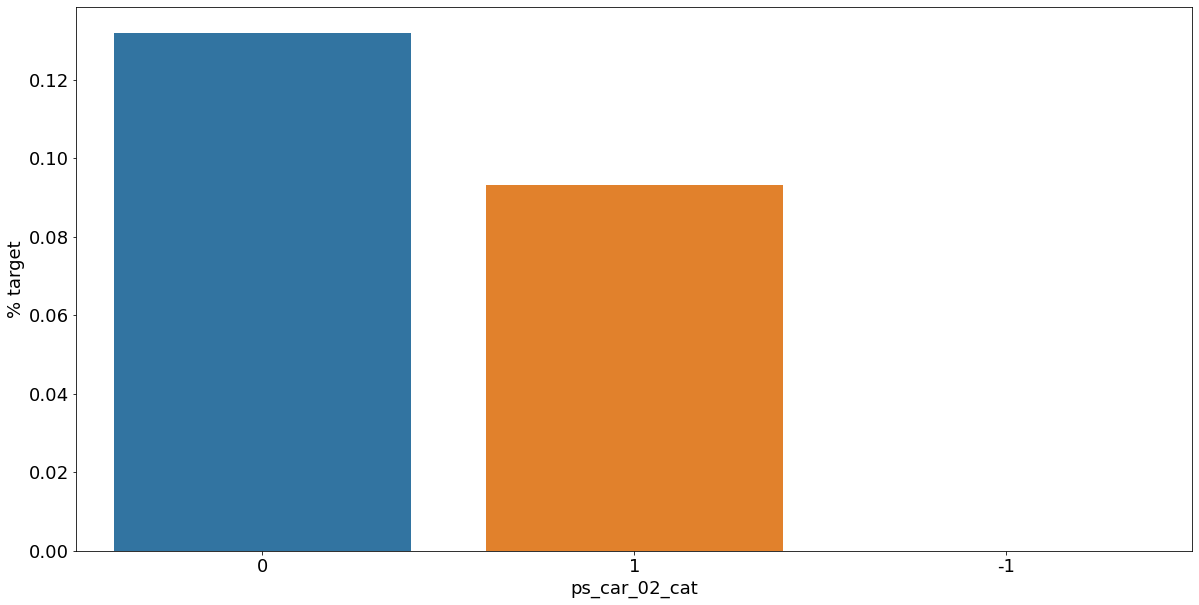

<Figure size 432x288 with 0 Axes>

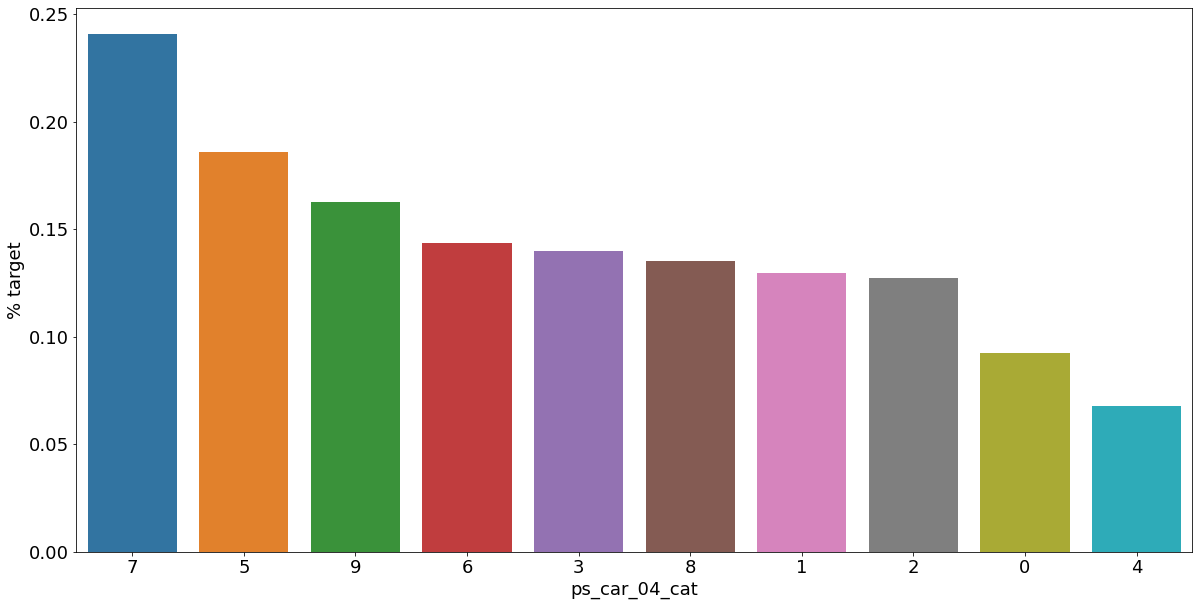

<Figure size 432x288 with 0 Axes>

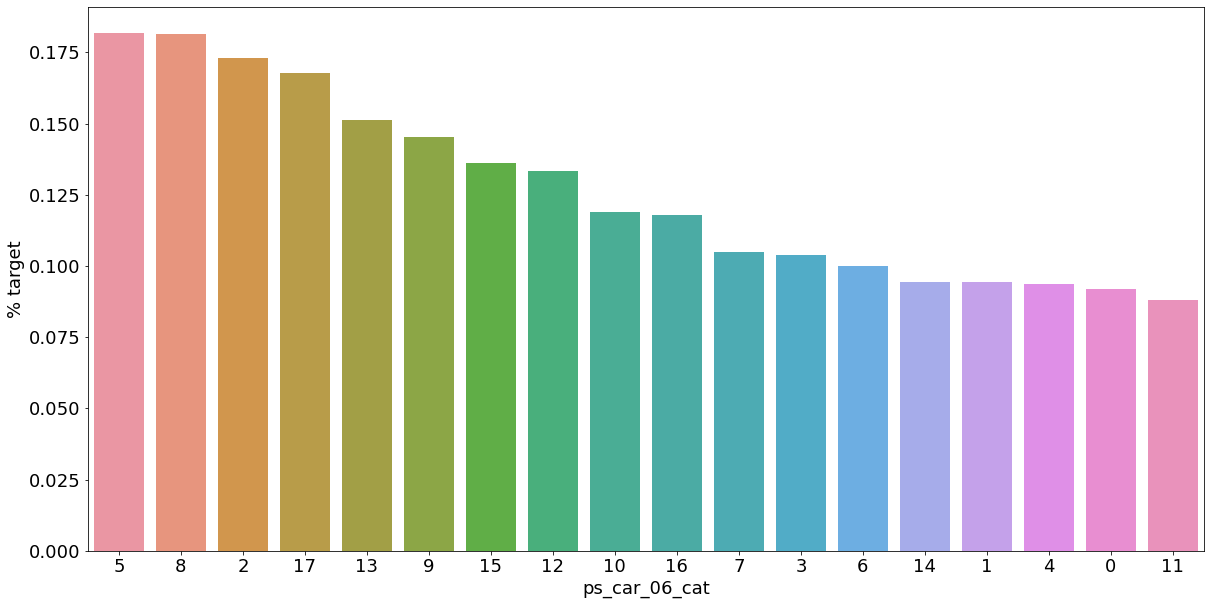

<Figure size 432x288 with 0 Axes>

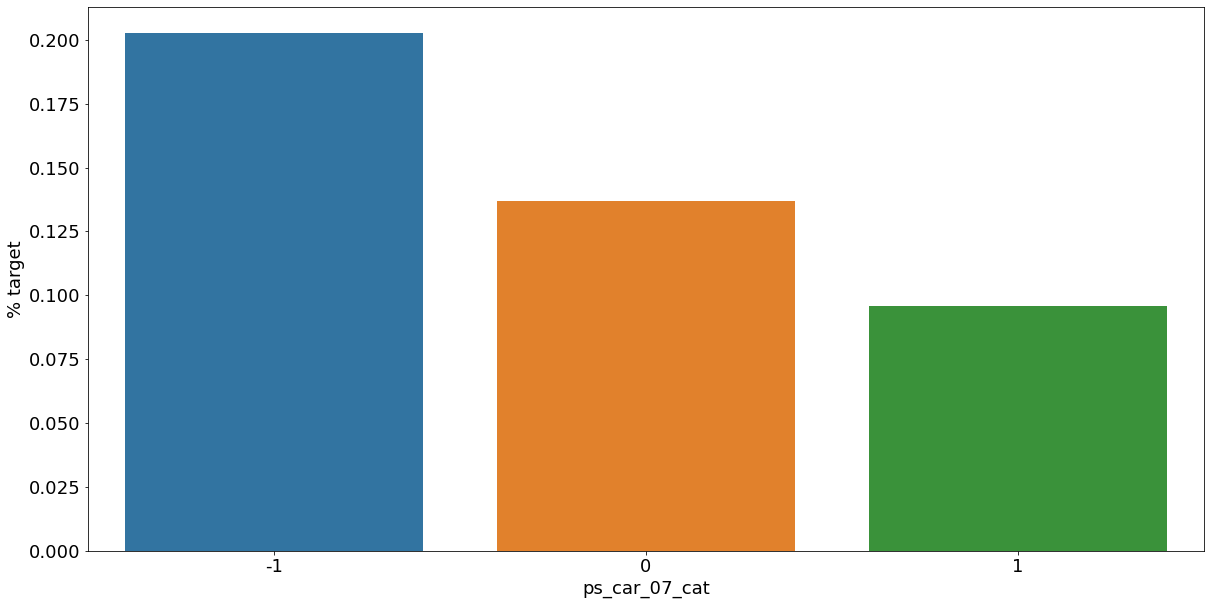

<Figure size 432x288 with 0 Axes>

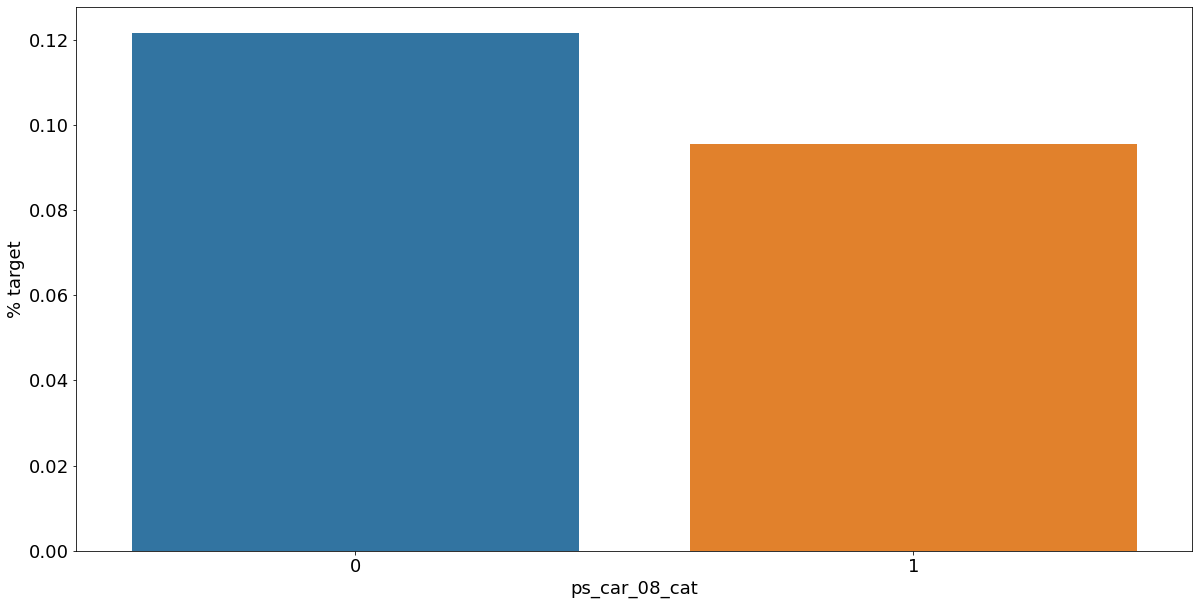

<Figure size 432x288 with 0 Axes>

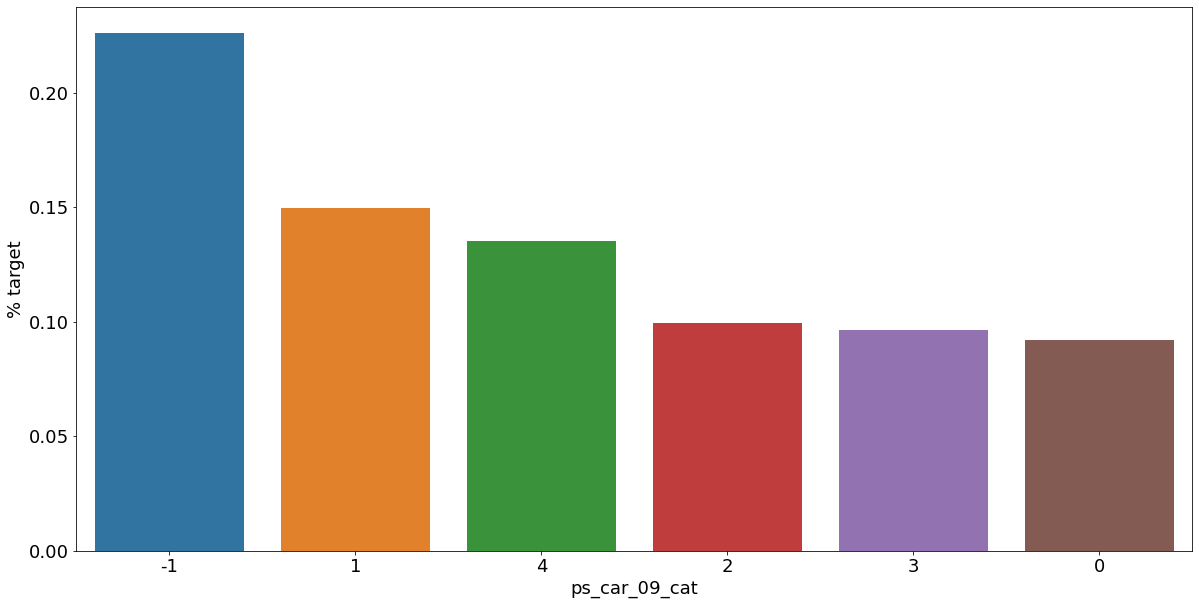

<Figure size 432x288 with 0 Axes>

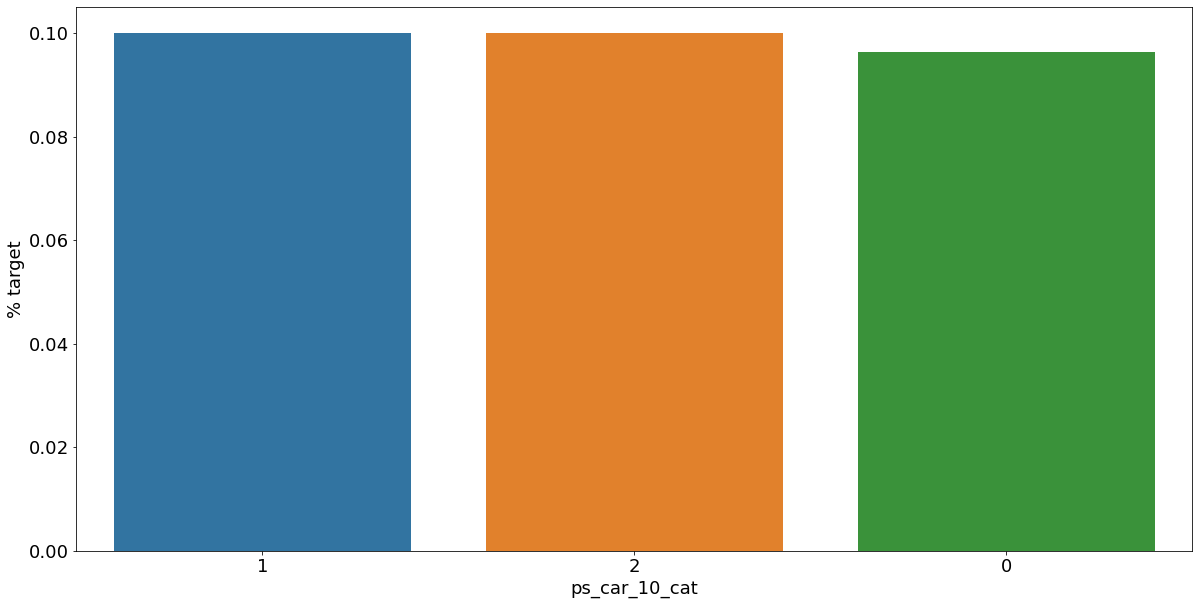

In [142]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20, 10))
    
    # 각 카테고리 value별 target=1의 비율 계산
    cat_prec = train[[f, 'target']].groupby([f], as_index=False).mean()
    cat_prec.sort_values(by='target', ascending=False, inplace=True)
    
    # target의 평균값을 기준으로 역순으로 정렬되도록 barplot 생성
    sns.barplot(ax=ax, x=f, y='target', data=cat_prec, order=cat_prec[f])
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show()

몇몇 피처에 결측치가 있었지만은 위의 figure에 보여줬듯이 `-1`을 그래도 놔두는 것이 좋은 방법이었음을 알 수 있다. 왜냐하면 결측치를 가진 고객이 보험 처리를 할 확률이 높기 때문이다.

### 7.2. Interval Features
Interval 피처끼리의 상관관계를 살펴보자.

In [143]:
def corr_heatmap(v):
    correlations = train[v].corr()

    # 두 색 사이의 colormap 생성
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={'shrink': .75})

    plt.show()

C:\Users\round\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


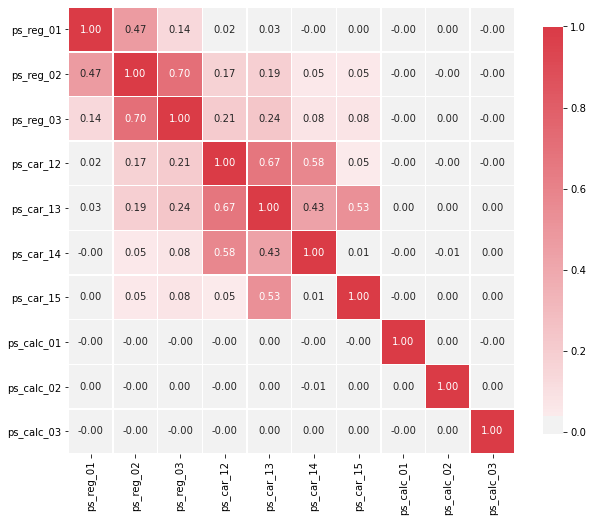

In [144]:
v = meta[(meta.level == 'interval') * (meta.keep)].index
corr_heatmap(v)

## References
* [캐글 필사 - 4. Porto Seguro Safe Driver Prediction](https://bkshin.tistory.com/entry/%EC%BA%90%EA%B8%80-4-Porto-Seguro-Safe-Driver-Prediction)
* [basic data type (기본적인 데이터 종류)](http://blog.heartcount.io/dd)
* [Data anonymization](https://en.wikipedia.org/wiki/Data_anonymization)